In [1]:
import json
import pathlib

import os

import numpy as np
import pandas as pd
import requests

os.chdir("/home/paolo/git/spotify-playlist-generator")

import torch
from src.utils.config import config as project_cfg
from src.db.queries.embeddings import get_closest_embedding, insert_embeddings, get_embeddings
from src.db.schemas.song_embedding import SongEmbedding
from src.db.tables.embeddings import SongEmbedding as SongEmbeddingSQL
from src.model.inference.inference import get_song_embedding


/home/paolo/git/spotify-playlist-generator/venv/lib/python3.11/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)


## Database setup

In [2]:
from sqlalchemy import create_engine
import sqlalchemy

config = {
    'user': 'spotify_playlist_generator',
    'password': 'spotify_playlist_generator',
    'host': 'localhost',
    'port': '5432',
    'database': 'spotify_playlist_generator',
}

DATABASE_URL: str = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:5432/{config['database']}"

# Create a SQLAlchemy engine and session
engine: sqlalchemy.engine.Engine = create_engine(DATABASE_URL, pool_pre_ping=True)

## Load data

In [3]:
from typing import Generator

paths: Generator = pathlib.Path("/home/paolo/git/spotify-playlist-generator/data/raw/songs").rglob("*.mp3")
tracks: list[dict[str, str]] = [{"song_id": x.stem, "audio_path": x} for x in paths]
tracks[0]

{'song_id': '6LtPIXlIzPOTF8vTecYjRe',
 'audio_path': PosixPath('/home/paolo/git/spotify-playlist-generator/data/raw/songs/2007/6LtPIXlIzPOTF8vTecYjRe.mp3')}

## Create pandas dataframe with songs info (name and artists)

In [4]:
import json

def get_songs_data() -> pd.DataFrame:
    songs_data = []
    for playlist in pathlib.Path("/home/paolo/git/spotify-playlist-generator/data/raw/json").rglob("*.json"):
        with playlist.open("r") as f:
            playlist_dict = json.load(f)
        for song in playlist_dict:
            song = song.get("track", {})
            songs_data.append([
                song.get("id"),
                song.get("name"),
                " - ".join([x.get("name") for x in song.get("artists", [{}])]),
                song.get("album", {}).get("name"),
            ])
    
    return pd.DataFrame(songs_data, columns=["id", "name", "artist", "album"])
songs_data = get_songs_data()
songs_data

,id,name,artist,album
0,1Ya8UT49Oc3oASVcsDqz60,Ace,Noname - Smino - Saba,Room 25
1,5mtfHX4VyY5D81WMaOHgHV,What More Can I Say,NxWorries - Anderson .Paak - Knxwledge,Yes Lawd!
2,3c5gLGgwRrE7sQYSNHCXEj,February 3rd,Jorja Smith,Lost & Found
3,0EN4QjJqiAufEh6g4xPNvC,Shadow Man,Noname - Smino - Phoelix - Saba,Telefone
4,0q75NwOoFiARAVp4EXU4Bs,Love Galore (feat. Travis Scott),SZA - Travis Scott,Ctrl
...,...,...,...,...
2143,7woxXKezUmdjGuHtR75nCT,Puoi (feat. Pinguini Tattici Nucleari),Fulminacci - Pinguini Tattici Nucleari,Infinito +1
2144,1m69ELEgE6k5ZWsap40ozt,Se Preparó,Ozuna,Odisea
2145,7JNh1cfm0eXjqFVOzKLyau,Mayores,Becky G - Bad Bunny,Mayores
2146,18NBoQ9SyURVcsPW6sP8tv,Frosinone,Calcutta,Mainstream (Deluxe Edition)


## Generate embedding and save them to the db

## Importante, questa funzione serve per avere gli embeddings e salvarli sul db

In [6]:
from sqlalchemy.orm import Session
from tqdm import tqdm

missing_embeddings: list[SongEmbedding] = []
playlist_songs_id: list[str] = [track["song_id"] for track in tracks]
with Session(engine) as session:
    embeddings_in_db = get_embeddings(session, playlist_songs_id)
    embeddings_in_db = set([x.id for x in embeddings_in_db])
    
    songs_to_insert = set(playlist_songs_id).difference(embeddings_in_db)
    for track in tqdm([x for x in tracks if x.get("song_id") in songs_to_insert]):
        missing_embeddings.append(get_song_embedding(track))

    
    if missing_embeddings:
        insert_embeddings(session, missing_embeddings)
    

  0%|          | 0/1897 [00:00<?, ?it/s]/home/paolo/git/spotify-playlist-generator/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(
100%|██████████| 1897/1897 [18:55<00:00,  1.67it/s]


## Get closest embeddings

In [7]:
from src.db.queries.embeddings import get_embeddings

with Session(engine) as session:
    # closest_embeddings: list[SongEmbeddingSQL] = get_closest_embedding(session, embeddings, project_cfg["model"]["k"])
    closest_embeddings = get_embeddings(session)


In [8]:
embeddings_dataframe = pd.DataFrame([[song_embedding.id, song_embedding.embedding.tolist()] for song_embedding in closest_embeddings], columns=["id", "embedding"])
songs_data.merge(embeddings_dataframe, on=["id"]).drop_duplicates(subset=["id"]).drop_duplicates(subset=["name", "artist"])

,id,name,artist,album,embedding
0,1Ya8UT49Oc3oASVcsDqz60,Ace,Noname - Smino - Saba,Room 25,"[0.0, 19170.478515625, 10433.6884765625, 9552...."
1,5mtfHX4VyY5D81WMaOHgHV,What More Can I Say,NxWorries - Anderson .Paak - Knxwledge,Yes Lawd!,"[0.0, 17555.447265625, 9283.181640625, 8391.63..."
2,3c5gLGgwRrE7sQYSNHCXEj,February 3rd,Jorja Smith,Lost & Found,"[0.0, 21363.23046875, 10815.544921875, 9667.48..."
3,0EN4QjJqiAufEh6g4xPNvC,Shadow Man,Noname - Smino - Phoelix - Saba,Telefone,"[0.0, 21112.97265625, 10029.1357421875, 9766.3..."
4,0q75NwOoFiARAVp4EXU4Bs,Love Galore (feat. Travis Scott),SZA - Travis Scott,Ctrl,"[0.0, 20858.72265625, 10287.8212890625, 10126...."
...,...,...,...,...,...
2123,7v4C0Bh0UUIr54Y7h86GPW,Giro con te,Calcutta,RELAX,"[46.6444091796875, 19357.359375, 10395.7910156..."
2124,7woxXKezUmdjGuHtR75nCT,Puoi (feat. Pinguini Tattici Nucleari),Fulminacci - Pinguini Tattici Nucleari,Infinito +1,"[0.0, 16617.615234375, 9819.83984375, 8569.975..."
2125,1m69ELEgE6k5ZWsap40ozt,Se Preparó,Ozuna,Odisea,"[12.45157241821289, 18059.08203125, 9774.43554..."
2126,7JNh1cfm0eXjqFVOzKLyau,Mayores,Becky G - Bad Bunny,Mayores,"[0.0, 17351.228515625, 9639.494140625, 7872.33..."


In [19]:
ids_to_check = ["4aVuWgvD0X63hcOCnZtNFA", "0eEXcw3JLVXcRxYrVYMy68", "3Ti0GdlrotgwsAVBBugv0I"]
ids_to_check_df = embeddings_dataframe[embeddings_dataframe["id"].isin(ids_to_check)]
song_names = songs_data.merge(ids_to_check_df, on=["id"]).query("id in @ids_to_check")["name"]
ids_to_check_df

,id,embedding
563,4aVuWgvD0X63hcOCnZtNFA,"[13.95114517211914, 15734.298828125, 7889.2690..."
945,3Ti0GdlrotgwsAVBBugv0I,"[0.0, 18301.841796875, 9186.69140625, 9150.425..."
1803,0eEXcw3JLVXcRxYrVYMy68,"[0.0, 22323.36328125, 9814.359375, 10377.92285..."


In [21]:
pd.DataFrame(np.array(embeddings_dataframe.embedding.tolist())).describe()



,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.0,1899.000000,1899.000000,1899.000000,1.899000e+03,...,1899.0,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.0,1899.000000,1899.000000
mean,66.339320,18572.250530,9639.360510,8771.999313,11877.482617,0.0,9721.026624,84.034494,490.056307,2.004173e+01,...,0.0,0.605499,3342.865346,1594.663985,2952.218605,3764.058263,311.593409,0.0,7406.634195,407.372849
std,167.415500,2302.771278,970.317919,1218.820374,1144.618991,0.0,1291.731966,194.634347,531.689567,8.488689e+01,...,0.0,18.440750,2026.611077,806.141666,1729.347705,2308.334508,488.612329,0.0,4187.643568,241.804665
min,-0.036501,12632.872070,6973.120605,5368.121094,8702.937500,0.0,4562.035156,-0.041547,-0.037930,-8.989751e-09,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,17008.194336,9000.717773,7931.413574,11066.875488,0.0,8840.585938,0.000000,15.097916,0.000000e+00,...,0.0,0.000000,1901.954834,1024.322144,1575.083191,1772.612793,0.000000,0.0,4391.588867,241.110413
50%,0.000000,18426.941406,9625.376953,8698.123047,11803.870117,0.0,9665.222656,0.000000,443.223511,0.000000e+00,...,0.0,0.000000,3071.911377,1500.079712,2629.320068,3479.782471,61.176331,0.0,7014.972656,394.544495
75%,54.044338,19993.707031,10247.735352,9530.521484,12614.855469,0.0,10473.258301,90.903309,774.661133,0.000000e+00,...,0.0,0.000000,4436.379883,2065.316406,4232.141357,5594.383789,458.680145,0.0,9758.110352,551.243256
max,2832.677490,27953.287109,14615.355469,15736.049805,17077.544922,0.0,14473.764648,2620.207031,5780.657715,1.832647e+03,...,0.0,733.422607,19287.775391,5208.542480,12074.660156,14400.371094,3479.754639,0.0,41797.035156,1627.797241


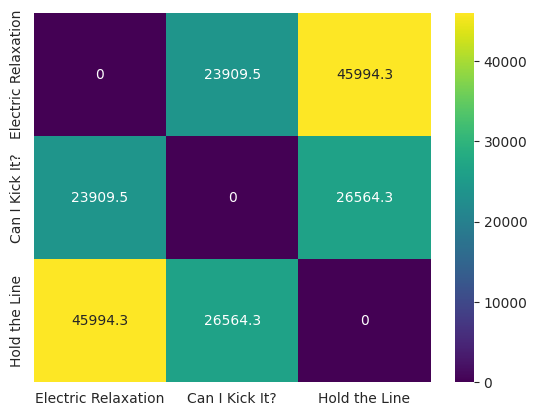

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(np.array(ids_to_check_df.embedding.to_list()), metric='euclidean', n_jobs=-1)
sns.heatmap(pd.DataFrame(distance_matrix), annot=True, cmap='viridis', fmt='g', yticklabels=song_names, xticklabels=song_names)
plt.show()

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
# Compute pairwise distances using Euclidean distance (you can choose a different metric)
distance_matrix = pairwise_distances(np.array(embeddings_dataframe.embedding.to_list()), metric='euclidean', n_jobs=-1)
sns.heatmap(pd.DataFrame(distance_matrix), annot=True, cmap='viridis', fmt='g')
plt.show()

ValueError: setting an array element with a sequence.

In [ ]:
# import numpy as np
# from sklearn.neighbors import NearestNeighbors
# import matplotlib.pyplot as plt
# 
# # Function to calculate k-distance for each data point
# def calculate_k_distance(data, k):
#     neighbors = NearestNeighbors(n_neighbors=k)
#     neighbors.fit(data)
#     distances, indices = neighbors.kneighbors(data, n_neighbors=k+1)
#     k_distances = distances[:, -1]
#     k_distances.sort()
#     return k_distances
# 
# # Function to plot the k-distance plot
# def plot_k_distance(k_distances, k):
#     plt.plot(range(1, len(k_distances) + 1), k_distances, marker='o')
#     plt.xlabel('Data Points (sorted by distance to k-th neighbor)')
#     plt.ylabel(f'Distance to {k}-th nearest neighbor')
#     plt.title(f'k-Distance Plot for DBSCAN')
#     plt.show()
# 
# # Function to find the optimal epsilon (elbow point) from the k-distance plot
# def find_optimal_epsilon(k_distances):
#     differences = np.diff(k_distances, 2)
#     # Find the index of the maximum difference, which indicates the elbow point
#     optimal_epsilon_index = np.argmax(differences) + 2
#     return k_distances[optimal_epsilon_index]
# 
# for k in [1,3,5,7,9, 11, 13]:
#     k_distances = calculate_k_distance(data=X, k=k)
#     plot_k_distance(k_distances, k=k)
#     
#     optimal_epsilon = find_optimal_epsilon(k_distances)
#     print(f'Optimal Epsilon: {optimal_epsilon}')

In [ ]:
# from sklearn.metrics.pairwise import pairwise_distances
# import seaborn as sns
# 
# for metric in ["euclidean", "cosine", "manhattan"]:
# # Example with cosine similarity
#     distance_matrix = pairwise_distances(X[:2], metric=metric)
#     sns.heatmap(pd.DataFrame(distance_matrix), annot=True, cmap='viridis', fmt='g')
#     
#     # Show the plot
#     plt.show()
#     # print(distance_matrix)

## Test DBSCAN

In [ ]:
# from sklearn.cluster import DBSCAN
# 
# for min_samples in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
#     for eps in range(500, 100_001, 500):
#         for metric in ["euclidean", "manhattan"]:
#             if eps == 0:
#                 continue
#             clustering_model: DBSCAN = DBSCAN(
#                 eps=float(eps), 
#                 min_samples=min_samples, 
#                 metric=metric, 
#                 metric_params=None, 
#                 algorithm='auto', 
#                 leaf_size=30, 
#                 p=None, 
#                 n_jobs=-1
#             )
#             results = clustering_model.fit_predict(X)
#             test_frame = pd.DataFrame(results).value_counts().to_frame().reset_index(drop=False, names=["cluster", "counts"])
#             songs_in_cluster = test_frame[test_frame["cluster"] == 0]["count"].tolist()
#             songs_in_cluster = songs_in_cluster[0] if songs_in_cluster else 0
#             outliers = test_frame[test_frame["cluster"] == -1]["count"].tolist()
#             if outliers:
#                 outliers = outliers[0]
#                 print(outliers, songs_in_cluster)
#             else:
#                 outliers = 0
#             
#             num_clusters = np.unique(results).shape[0]
#             if outliers < 100 and songs_in_cluster < results.shape[0] // 2 and 10 < num_clusters < 150:
#                 print(f"Epsilon: {eps} - Minimum samples: {min_samples} - num clusters: {len(np.unique(results))} - metric: {metric} - outliers: {outliers} - songs in cluster 0: {songs_in_cluster}")

## Test agglomerative clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering


for threshold in range(500, 100_001, 500):
    clustering_model: AgglomerativeClustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold)

    results = clustering_model.fit_predict(X)
    dataframe = pd.DataFrame(results).value_counts().to_frame(name="counts").reset_index(drop=False, names=["cluster"])
    num_clusters = dataframe.shape[0]
    smallest_cluster = dataframe.counts.min()
    biggest_cluster = dataframe.counts.max()
    if 10 < num_clusters < 150 and biggest_cluster < 200 and smallest_cluster > 1:
        print(f"threshold: {threshold} - num clusters: {len(np.unique(results))} - smallest_cluster: {smallest_cluster} - biggest_cluster: {biggest_cluster}")
        

threshold: 16500 - num clusters: 147 - smallest_cluster: 1 - biggest_cluster: 34
threshold: 17000 - num clusters: 142 - smallest_cluster: 1 - biggest_cluster: 36
threshold: 17500 - num clusters: 136 - smallest_cluster: 1 - biggest_cluster: 36
threshold: 18000 - num clusters: 130 - smallest_cluster: 1 - biggest_cluster: 39
threshold: 18500 - num clusters: 120 - smallest_cluster: 1 - biggest_cluster: 54
threshold: 19000 - num clusters: 115 - smallest_cluster: 1 - biggest_cluster: 54
threshold: 19500 - num clusters: 108 - smallest_cluster: 1 - biggest_cluster: 54
threshold: 20000 - num clusters: 108 - smallest_cluster: 1 - biggest_cluster: 54
threshold: 20500 - num clusters: 101 - smallest_cluster: 1 - biggest_cluster: 69
threshold: 21000 - num clusters: 99 - smallest_cluster: 1 - biggest_cluster: 69
threshold: 21500 - num clusters: 95 - smallest_cluster: 1 - biggest_cluster: 69
threshold: 22000 - num clusters: 94 - smallest_cluster: 1 - biggest_cluster: 69
threshold: 22500 - num clusters

In [31]:
clustering_model: AgglomerativeClustering = AgglomerativeClustering(n_clusters=None, distance_threshold=30_000)
results = clustering_model.fit_predict(X)

In [42]:
df = pd.DataFrame(zip(results, np.array([x.id for x in tmp])), columns=["cluster", "id"])
df["spotify_uri"] = f"spotify:track:" + df['id']
# df = df[df["cluster"] != -1]
df = df.merge(songs_data, on = "id").drop_duplicates(subset=["id"]).drop_duplicates(subset=["name", "artist"])
df

,cluster,id,spotify_uri,name,artist,album
0,35,6LtPIXlIzPOTF8vTecYjRe,spotify:track:6LtPIXlIzPOTF8vTecYjRe,Bleeding Love,Leona Lewis,Spirit
1,29,1BLfQ6dPXmuDrFmbdfW7Jl,spotify:track:1BLfQ6dPXmuDrFmbdfW7Jl,A Little Piece of Heaven,Avenged Sevenfold,Avenged Sevenfold
2,9,1Rz8BPFzWYOItgmZxb7ZJY,spotify:track:1Rz8BPFzWYOItgmZxb7ZJY,I Ain't Mad At Cha,2Pac,The Best of 2Pac
3,27,4E6cwWJWZw2zWf7VFbH7wf,spotify:track:4E6cwWJWZw2zWf7VFbH7wf,Love Song,Sara Bareilles,Little Voice
4,10,0SPOBDQDwcLFC3hFjqZX5V,spotify:track:0SPOBDQDwcLFC3hFjqZX5V,Dancing In The Rain,Blu & Exile - Blu - Exile,Below The Heavens
...,...,...,...,...,...,...
2122,5,0trHOzAhNpGCsGBEu7dOJo,spotify:track:0trHOzAhNpGCsGBEu7dOJo,N.Y. State of Mind,Nas,Illmatic
2123,41,7G3lxTsMfSx4yarMkfgnTC,spotify:track:7G3lxTsMfSx4yarMkfgnTC,The World Is Yours,Nas,Illmatic
2124,44,7nYvUtkQMx1v80S2FH2s9J,spotify:track:7nYvUtkQMx1v80S2FH2s9J,Regulate,Warren G - Nate Dogg,Regulate… G Funk Era
2126,52,1nsbj6cQQmfp9x7Mlmtphl,spotify:track:1nsbj6cQQmfp9x7Mlmtphl,Sittin' In My Car,Slick Rick,Behind Bars


In [43]:
df.query("cluster == 1")[["id", "name", "artist", "album"]].sort_values(by="artist")

,id,name,artist,album
1778,5qfZRNjt2TkHEL12r3sDEU,Everglow,Coldplay,A Head Full of Dreams
1420,0UtAEonU5MhbGljzcaa5Kx,Alfred - Outro,Eminem,Music To Be Murdered By - Side B (Deluxe Edition)
422,4UsYN68FV4laJT0ppCswS3,Un giudice,Fabrizio De André,"Non Al Denaro, Non All'Amore, Ne Al Cielo"
572,7mlOO9JBY4vhzK7PniqUK8,Il gorilla,Fabrizio De André,Volume 3
893,5ZERO6q1hX4ozsvyv7VijR,Per I Tuoi Larghi Occhi,Fabrizio De André,Peccati Di Gioventu
2011,2hwXMI3V9f6Tfcowxo6Uzv,Le passanti - Da una poesia di Antoine Pol,Fabrizio De André,Fabrizio De André Opere Complete
2014,6oaaqyWZvG0dc74E9Cg3ca,Hotel Supramonte,Fabrizio De André,Fabrizio De André Opere Complete
1784,0J1lKQRsBEkpgPS9d3VamY,Cry For Love - Pt. 2,James Horner,Southpaw (Music From And Inspired By The Motio...
1795,2VBMOiho6P9N3buhDzjLjF,Cry For Love - Pt. 1,James Horner,Southpaw (Music From And Inspired By The Motio...
1233,5O3CMdTwoBLzkekDvY2OwT,Ipa,Jinsang,In Flight


In [14]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

os.environ["SPOTIPY_CLIENT_ID"] = "bf621646332d4c9c82c6e6d1fd8a8352"
os.environ["SPOTIPY_CLIENT_SECRET"] = "0ecda4e3308e4340a26b519d0647b2bf"
os.environ["SPOTIPY_REDIRECT_URI"] = "http://localhost/callback/"

sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        scope="playlist-modify-private playlist-read-private",
        redirect_uri="http://localhost/callback/",
        client_id=os.getenv("SPOTIFY_CLIENT_ID"),
        client_secret=os.getenv("SPOTIFY_CLIENT_SECRET"),
        show_dialog=False,
        cache_path="token.txt",
    )
)
user = sp.current_user()

User authentication requires interaction with your web browser. Once you enter your credentials and give authorization, you will be redirected to a url.  Paste that url you were directed to to complete the authorization.
Using `localhost` as redirect URI without a port. Specify a port (e.g. `localhost:8080`) to allow automatic retrieval of authentication code instead of having to copy and paste the URL your browser is redirected to.
Opened https://accounts.spotify.com/authorize?client_id=bf621646332d4c9c82c6e6d1fd8a8352&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%2Fcallback%2F&scope=playlist-modify-private+playlist-read-private in your browser
Opening in existing browser session.


In [13]:
max_songs_per_request: int = 100
for cluster in df.cluster.unique():
    songs_uri: list[str] = df[df.cluster == cluster].spotify_uri.tolist()
    playlist = sp.user_playlist_create(user=user.get("id"),name=f"Playlist {cluster}", public=False, description=f"Playlist using the songs in the cluster {cluster}")

    if len(songs_uri) < max_songs_per_request:
        sp.playlist_add_items(playlist.get("id"), items=songs_uri)
        continue
        
    num_chunks: int = len(songs_uri) // max_songs_per_request + 1 
    for i in range(num_chunks):
        sp.playlist_add_items(playlist.get("id"), items=songs_uri[i*max_songs_per_request: (i+1)*max_songs_per_request])


User authentication requires interaction with your web browser. Once you enter your credentials and give authorization, you will be redirected to a url.  Paste that url you were directed to to complete the authorization.
Using `localhost` as redirect URI without a port. Specify a port (e.g. `localhost:8080`) to allow automatic retrieval of authentication code instead of having to copy and paste the URL your browser is redirected to.
Opened https://accounts.spotify.com/authorize?client_id=bf621646332d4c9c82c6e6d1fd8a8352&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%2Fcallback%2F&scope=playlist-modify-private+playlist-read-private in your browser
Opening in existing browser session.


SpotifyOauthError: error: invalid_request, error_description: code must be supplied

{'href': 'https://api.spotify.com/v1/users/paolo.s16/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': '',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/7MkjiFngObIiQ3xenYWRLq'},
   'href': 'https://api.spotify.com/v1/playlists/7MkjiFngObIiQ3xenYWRLq',
   'id': '7MkjiFngObIiQ3xenYWRLq',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab67616d0000b273c08d5fa5c0f1a834acef5100',
     'width': 640}],
   'name': 'Playlist 42',
   'owner': {'display_name': 'paolo_sofia',
    'external_urls': {'spotify': 'https://open.spotify.com/user/paolo.s16'},
    'href': 'https://api.spotify.com/v1/users/paolo.s16',
    'id': 'paolo.s16',
    'type': 'user',
    'uri': 'spotify:user:paolo.s16'},
   'primary_color': None,
   'public': False,
   'snapshot_id': 'MixmNDllMTM1YjhkNjFmNWZkYmEzZDg5NDkzM2E4MGI4ZTBhMGQ3MGZk',
   'tracks': {'href': 'https://api.spotify.com/v1/playlists/7MkjiFngObIiQ3xenYWRLq/tracks',
    'total': 2},
   'typ

In [16]:
playlists = sp.user_playlists(user=user.get("id"))
playlists

{'href': 'https://api.spotify.com/v1/users/paolo.s16/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': 'Playlist using the songs in the cluster 42',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/7MkjiFngObIiQ3xenYWRLq'},
   'href': 'https://api.spotify.com/v1/playlists/7MkjiFngObIiQ3xenYWRLq',
   'id': '7MkjiFngObIiQ3xenYWRLq',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab67616d0000b273c08d5fa5c0f1a834acef5100',
     'width': 640}],
   'name': 'Playlist 42',
   'owner': {'display_name': 'paolo_sofia',
    'external_urls': {'spotify': 'https://open.spotify.com/user/paolo.s16'},
    'href': 'https://api.spotify.com/v1/users/paolo.s16',
    'id': 'paolo.s16',
    'type': 'user',
    'uri': 'spotify:user:paolo.s16'},
   'primary_color': None,
   'public': False,
   'snapshot_id': 'NCw5ZThlMWE1ZjgwY2MzOTAyZGNjZDY4MjA4Yzg5MGI4MjE3MzVjZDg2',
   'tracks': {'href': 'https://api.spotify.com/v1/playlists/7MkjiFngObIiQ3

In [23]:
for plist in playlists.get("items"):
    if "cluster" in plist.get("description"):
        print("deleting playlist", plist.get("id"))
        sp.current_user_unfollow_playlist(plist.get("id"))
    

deleting playlist 7MkjiFngObIiQ3xenYWRLq
deleting playlist 0hTVvBgSfMIflNchZXDvrg
deleting playlist 3NosKXlOE1YszMn1SlcKIC
deleting playlist 18doYEUy8d08b6hliR2tFL
deleting playlist 0dfGnFG2Lg8HOrvOinXeFZ
deleting playlist 360LJceO5oBgDBn40TlXRv
deleting playlist 6Xk1FQmJwo8imlx8NdqaEr
deleting playlist 7a9Rd1VWVLls4C88fI3VGK
deleting playlist 0BVKVMCYbdC4dej71eTV57
deleting playlist 78sm2Vw7Qx9YIWD5MeyJIk
deleting playlist 3vXRRTkM6akx79kxJ9N1Rk
deleting playlist 2jVx2wP1cQbQGe6qyBhx4p
deleting playlist 0O4ooVUsHPtIyGSDjeWkBK
deleting playlist 0rdl0SEYPOCpHxECILVwSS
deleting playlist 0RsvGOZVKvZSNoLfvjorQ2
deleting playlist 7qbpvQ7abHCVCE2ik0eLBC
deleting playlist 6Se3AqnSm9C6C66fAFNZ4z
deleting playlist 4ywjMvpAMcnNGaWZrgezbg
deleting playlist 630VJ8E0eo8gs2AlS9XUrh
deleting playlist 2BROwMmNwg7t9ls6JwRRD0
deleting playlist 4V6f5yOkNWUhTlBDQr7bpL
deleting playlist 2QNSmSrZdTJ1Wlvr6DKHpR
deleting playlist 5XnJQlw059VqK4nBTdssfi
deleting playlist 2BPnzlWhCcYelIUFEkPmxU
deleting playlis